# **1. Perkenalan Dataset**


Dataset yang digunakan adalah Beverage Sales yang bersumber dari proyek Membangun Proyek Machine Learning, dengan kriteria minimal 1.000 baris yang digunakan pada dataset maka saya gunakan 20.000 baris pada dataset untuk dilakukan clustering.


# **2. Import Library**

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# **3. Memuat Dataset**

In [70]:
df = pd.read_csv('/content/sample_data/Dataset_inisiasi.csv')

In [71]:
# Memastikan dataset terbaca di notebook
print(df.head())

  Order_ID Customer_ID Customer_Type             Product     Category  \
0     ORD1     CUS1496           B2B          Vio Wasser        Water   
1     ORD1     CUS1496           B2B               Evian        Water   
2     ORD1     CUS1496           B2B              Sprite  Soft Drinks   
3     ORD1     CUS1496           B2B  Rauch Multivitamin       Juices   
4     ORD1     CUS1496           B2B        Gerolsteiner        Water   

   Unit_Price  Quantity  Discount  Total_Price             Region  Order_Date  
0        1.66        53      0.10        79.18  Baden-Württemberg  2023-08-23  
1        1.56        90      0.10       126.36  Baden-Württemberg  2023-08-23  
2        1.17        73      0.05        81.14  Baden-Württemberg  2023-08-23  
3        3.22        59      0.10       170.98  Baden-Württemberg  2023-08-23  
4        0.87        35      0.10        27.40  Baden-Württemberg  2023-08-23  


In [72]:
print("\nDataset Shape:", df.shape)


Dataset Shape: (20000, 11)


# **4. Exploratory Data Analysis (EDA)**

In [73]:
# Informasi dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order_ID       20000 non-null  object 
 1   Customer_ID    20000 non-null  object 
 2   Customer_Type  20000 non-null  object 
 3   Product        20000 non-null  object 
 4   Category       20000 non-null  object 
 5   Unit_Price     20000 non-null  float64
 6   Quantity       20000 non-null  int64  
 7   Discount       20000 non-null  float64
 8   Total_Price    20000 non-null  float64
 9   Region         20000 non-null  object 
 10  Order_Date     20000 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.7+ MB
None


In [74]:
# Mengecek statistik deskriptif (numerik) dataset
print(df.describe())

         Unit_Price      Quantity      Discount   Total_Price
count  20000.000000  20000.000000  20000.000000  20000.000000
mean       5.759278     23.310100      0.030023    129.260358
std       14.755431     27.019251      0.045046    498.860934
min        0.320000      1.000000      0.000000      0.390000
25%        1.070000      6.000000      0.000000      8.540000
50%        1.765000     11.000000      0.000000     21.140000
75%        3.210000     31.000000      0.050000     69.270000
max      137.360000    100.000000      0.150000  11325.330000


In [75]:
# Mengecek statistik deskriptif (kategorikal) dataset
print(df.describe(exclude=np.number))

       Order_ID Customer_ID Customer_Type        Product     Category  \
count     20000       20000         20000          20000        20000   
unique     6702        4928             2             47            4   
top     ORD6697     CUS1614           B2C  Granini Apple  Soft Drinks   
freq          5          19         12823            754         5062   

         Region  Order_Date  
count     20000       20000  
unique       16        1093  
top     Hamburg  2021-03-24  
freq       1465          58  


In [76]:
# Mengecek apakah ada data yang kosong / null
print(df.isnull().sum())

Order_ID         0
Customer_ID      0
Customer_Type    0
Product          0
Category         0
Unit_Price       0
Quantity         0
Discount         0
Total_Price      0
Region           0
Order_Date       0
dtype: int64


# **5. Data Preprocessing**

In [77]:
# Menghapus kolom yang tidak diperlukan untuk clustering
columns_to_drop = ['Order_ID', 'Customer_ID', 'Order_Date', 'Product', 'Region', 'Category']
df_processed = df.drop(columns=columns_to_drop)

In [78]:
print("\nData setelah penghapusan kolom:")
print(df_processed.head())


Data setelah penghapusan kolom:
  Customer_Type  Unit_Price  Quantity  Discount  Total_Price
0           B2B        1.66        53      0.10        79.18
1           B2B        1.56        90      0.10       126.36
2           B2B        1.17        73      0.05        81.14
3           B2B        3.22        59      0.10       170.98
4           B2B        0.87        35      0.10        27.40


In [79]:
# Preprocessing untuk kolom kategorikal dan numerik
preprocessor = Pipeline([
    ('encoder', ColumnTransformer([
        ('categorical', OneHotEncoder(), make_column_selector(dtype_exclude=np.number))
    ], remainder='passthrough')),
    ('scaler', StandardScaler())
])

In [80]:
# Transformasi data
df_preprocessed = preprocessor.fit_transform(df_processed)
print("\nData setelah preprocessing:")
print(pd.DataFrame(df_preprocessed).head())


Data setelah preprocessing:
          0         1         2         3         4         5
0  1.336667 -1.336667 -0.277822  1.098870  1.553513 -0.100392
1  1.336667 -1.336667 -0.284599  2.468298  1.553513 -0.005814
2  1.336667 -1.336667 -0.311031  1.839101  0.443504 -0.096463
3  1.336667 -1.336667 -0.172095  1.320939  1.553513  0.083632
4  1.336667 -1.336667 -0.331363  0.432662  1.553513 -0.204191


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [81]:
# Analisis Clustering menggunakan K-Means (Menentukan jumlah cluster yang optimal), menentukan berapa jumlah cluster yang akan diuji
range_n_clusters = range(2, 11)
silhouette_scores = []

In [82]:
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_preprocessed)
    silhouette_avg = silhouette_score(df_preprocessed, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg:.4f}")

best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nJumlah cluster terbaik: {best_n_clusters} (Score: {max(silhouette_scores):.4f})")

n_clusters = 2, Silhouette Score = 0.7188
n_clusters = 3, Silhouette Score = 0.7499
n_clusters = 4, Silhouette Score = 0.7040
n_clusters = 5, Silhouette Score = 0.7292
n_clusters = 6, Silhouette Score = 0.7346
n_clusters = 7, Silhouette Score = 0.7385
n_clusters = 8, Silhouette Score = 0.7057
n_clusters = 9, Silhouette Score = 0.7042
n_clusters = 10, Silhouette Score = 0.4234

Jumlah cluster terbaik: 3 (Score: 0.7499)


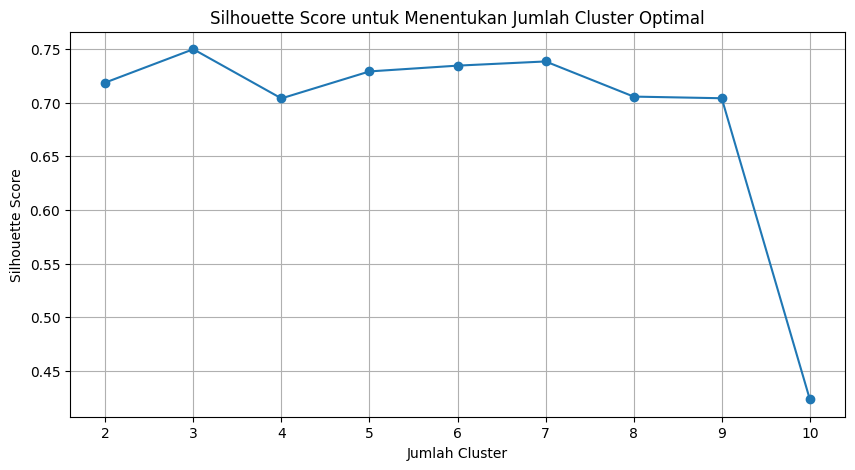

In [83]:
# Visualiasi plot hasil silhouette score
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score untuk Menentukan Jumlah Cluster Optimal")
plt.grid(True)
plt.show()

## **b. Evaluasi Model Clustering**

In [84]:
# Melatih model K-Means berdasarkan cluster terbaik
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
clusters = kmeans.fit_predict(df_preprocessed)
best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Melatih model dengan {best_n_clusters} cluster dengan hasil silhouette score terbaik: {best_score:.4f}")

Melatih model dengan 3 cluster dengan hasil silhouette score terbaik: 0.7499


## **c. Feature Selection (Opsional)**

In [85]:
# PCA untuk reduksi dimensi, mempertahankan 95% varians
pca_95 = PCA(n_components=0.95)
X_pca = pca_95.fit_transform(df_preprocessed)
print(f"Shape setelah PCA: {X_pca.shape}")
print(f"Jumlah komponen PCA: {pca_95.n_components_}")

Shape setelah PCA: (20000, 4)
Jumlah komponen PCA: 4


In [86]:
# Clustering dengan Data PCA
pca_clusters = kmeans.fit_predict(X_pca)
pca_score = silhouette_score(X_pca, pca_clusters)

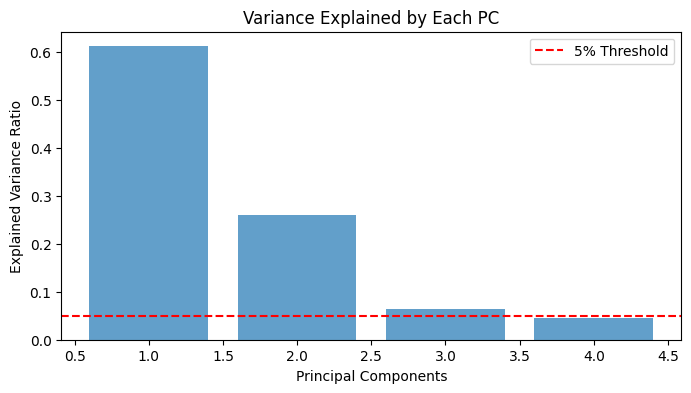

In [87]:
plt.figure(figsize=(8, 4))
plt.bar(range(1, pca_95.n_components_+1), pca_95.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each PC')
plt.axhline(y=0.05, color='r', linestyle='--', label='5% Threshold')
plt.legend()
plt.show()

In [88]:
pca_3 = PCA(n_components=3)  # Dari hasil visualisasi diperoleh komponen best PCA terbaik yaitu sebanyak 3 komponen
X_pca = pca_3.fit_transform(df_preprocessed)

In [89]:
# Hasil clustering
kmeans_pca = KMeans(n_clusters=3, random_state=42)
labels = kmeans_pca.fit_predict(X_pca)
silhouette_avg = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.7920


## **d. Visualisasi Hasil Clustering**

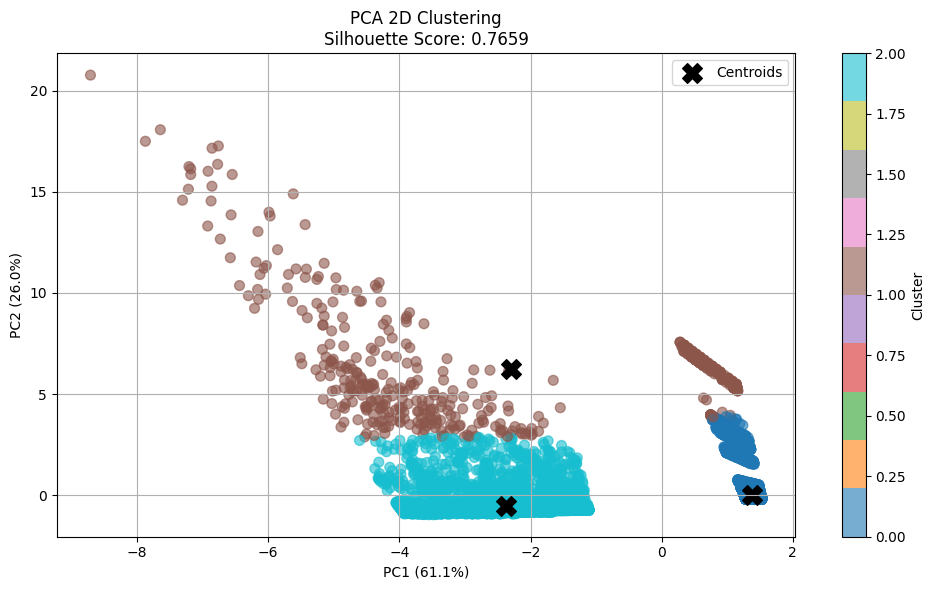

In [90]:
# Plot PCA Clustering 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=labels, cmap='tab10', alpha=0.6, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='black', marker='X', label='Centroids')
plt.xlabel(f'PC1 ({pca_3.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_3.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'PCA 2D Clustering\nSilhouette Score: {pca_score:.4f}')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# Analisis perbandingan
comparison_data = {
    'Metode': ['Sebelum PCA', 'Sesudah PCA'],
    'Silhouette Score': [best_score, silhouette_avg],
    'Jumlah Fitur': [df_preprocessed.shape[1], pca_3.n_components_]
}

In [92]:
# Mengubah ke DataFrame untuk seaborn
df_compare = pd.DataFrame(comparison_data)

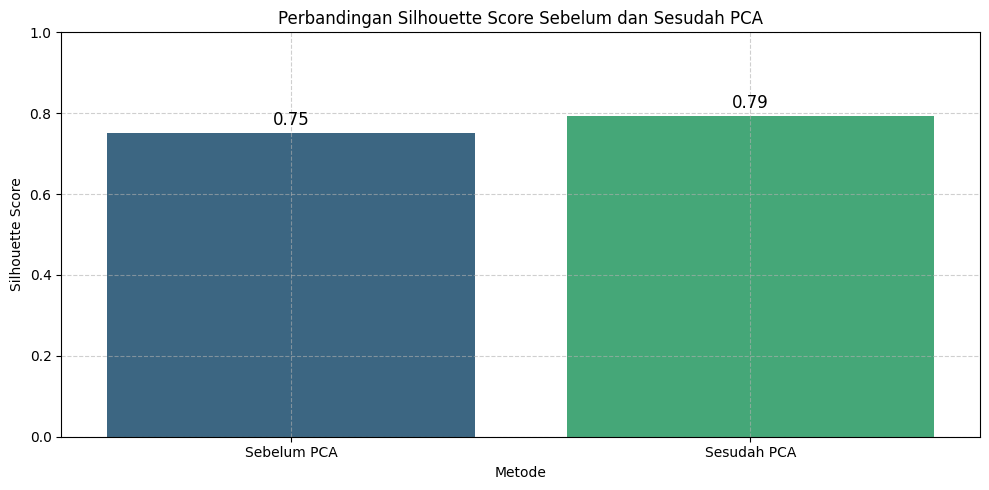

In [93]:
# Bar plot Silhouette Score
plt.figure(figsize=(10, 5))
sns.barplot(x='Metode', y='Silhouette Score', data=df_compare, palette='viridis')
plt.title('Perbandingan Silhouette Score Sebelum dan Sesudah PCA')
plt.ylim(0, 1)
for index, row in df_compare.iterrows():
    plt.text(index, row['Silhouette Score'] + 0.02, f"{row['Silhouette Score']:.2f}", ha='center', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

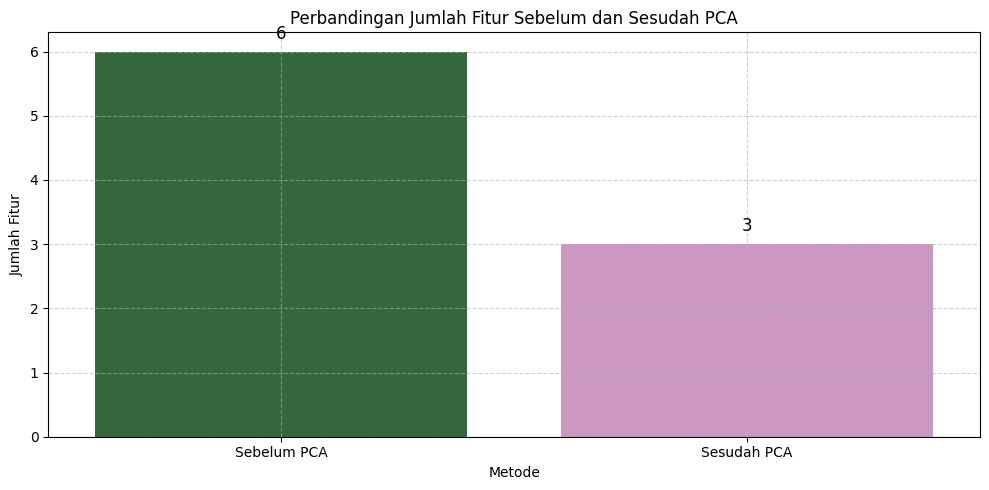

In [94]:
# Bar plot Jumlah Fitur
plt.figure(figsize=(10, 5))
sns.barplot(x='Metode', y='Jumlah Fitur', data=df_compare, palette='cubehelix')
plt.title('Perbandingan Jumlah Fitur Sebelum dan Sesudah PCA')
for index, row in df_compare.iterrows():
    plt.text(index, row['Jumlah Fitur'] + 0.2, f"{row['Jumlah Fitur']}", ha='center', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

In [95]:
# Menggabungkan data asli dengan label cluster
df_labeled = df_processed.copy()
df_labeled['Cluster'] = clusters

In [96]:
# Tampilkan 5 baris pertama
print(df_labeled.head())

  Customer_Type  Unit_Price  Quantity  Discount  Total_Price  Cluster
0           B2B        1.66        53      0.10        79.18        1
1           B2B        1.56        90      0.10       126.36        1
2           B2B        1.17        73      0.05        81.14        1
3           B2B        3.22        59      0.10       170.98        1
4           B2B        0.87        35      0.10        27.40        1


In [97]:
# Analisis statistik per cluster
# Menggunakan library pandas untuk menampilkan semua kolom
pd.set_option('display.max_columns', None)
# Group by Cluster dan hitung statistik
cluster_stats = df_labeled.groupby('Cluster').agg({
    'Unit_Price': ['mean', 'median', 'min', 'max', 'std', 'count', 'sum'],
    'Quantity': ['mean', 'median', 'min', 'max', 'std', 'count', 'sum'],
    'Discount': ['mean', 'median', 'min', 'max', 'std', 'count', 'sum'],
    'Total_Price': ['mean', 'median', 'min', 'max', 'std', 'count', 'sum']
})

# Tampilkan
print("Analisis Statistik per Cluster:")
display(cluster_stats)

Analisis Statistik per Cluster:


Unit_Price                                                    \
              mean median    min     max        std  count       sum   
Cluster                                                                
0         4.304201   1.71   0.46   72.70   9.506340  12627  54349.14   
1         3.428805   1.74   0.32   56.65   6.017758   6879  23586.75   
2        75.404190  71.15  24.07  137.36  31.971837    494  37249.67   

          Quantity                                            Discount         \
              mean median min  max        std  count     sum      mean median   
Cluster                                                                         
0         8.020591    8.0   1   15   4.347169  12627  101276  0.000000   0.00   
1        49.806076   49.0   1  100  28.907372   6879  342616  0.083137   0.10   
2        45.161943   45.0   1  100  34.797561    494   22310  0.057794   0.05   

                                              Total_Price                    \
          min   max       std  count     sum         mean    median     min   
Cluster                                                                       
0        0.00  0.00  0.000000  12627    0.00    34.221959    12.880    0.46   
1        0.05  0.15  0.034092   6879  571.90   140.986053    73.560    0.39   
2        0.00  0.15  0.053621    494   28.55  2395.229615  1921.385  106.01   

                                                   
              max          std  count         sum  
Cluster                                            
0          856.65    85.893707  12627   432120.67  
1         1917.75   223.380942   6879   969843.06  
2        11325.33  1957.531698    494  1183243.43

<Figure size 1000x500 with 0 Axes>

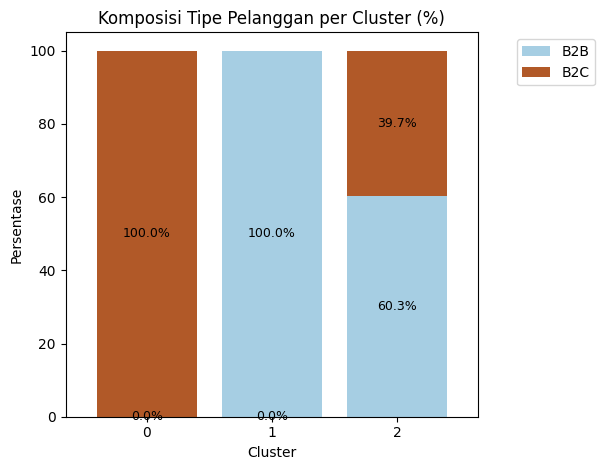

In [98]:
# Komposisi Tipe Pelanggan (Customer_Type)
plt.figure(figsize=(10,5))
ax = (df_labeled.groupby(['Cluster','Customer_Type']).size().unstack()
     .div(df_labeled.groupby('Cluster').size(), axis=0).mul(100)
     .plot.bar(stacked=True, colormap='Paired', width=0.8))

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

plt.title('Komposisi Tipe Pelanggan per Cluster (%)')
plt.ylabel('Persentase')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.3,1))
plt.tight_layout()
plt.show()

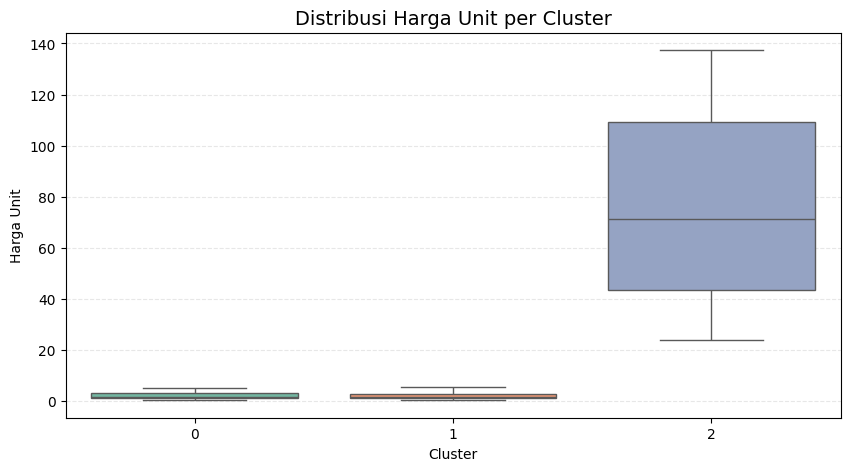

In [99]:
# Distribusi harga unit per cluster
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_labeled, x='Cluster', y='Unit_Price', palette='Set2', showfliers=False)
plt.title('Distribusi Harga Unit per Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Harga Unit')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

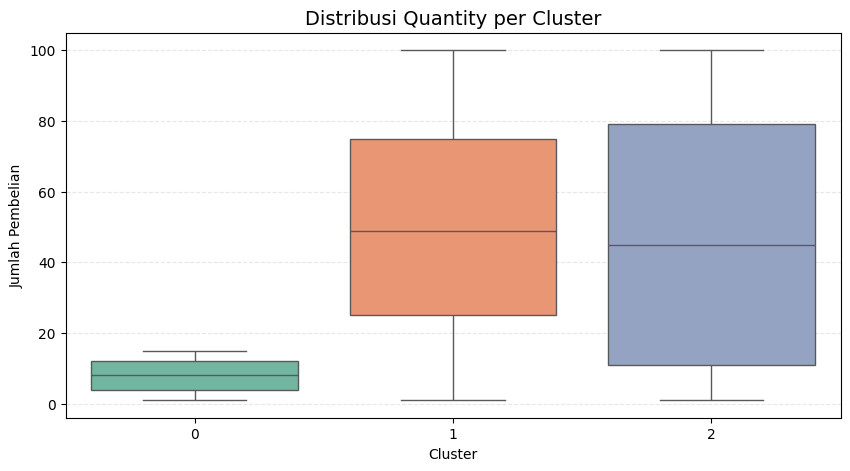

In [100]:
# Distribusi quantity per kluster
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_labeled,
    x='Cluster',
    y='Quantity',
    palette='Set2',
    showfliers=False
)
plt.title('Distribusi Quantity per Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pembelian')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

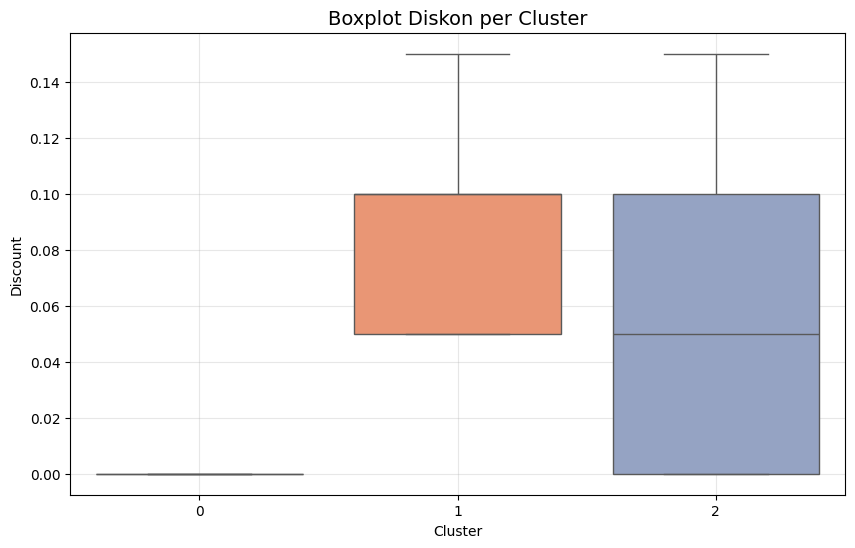

In [101]:
# Distribusi diskon per kluster
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_labeled,
    x='Cluster',
    y='Discount',
    palette='Set2'
)
plt.title('Boxplot Diskon per Cluster', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

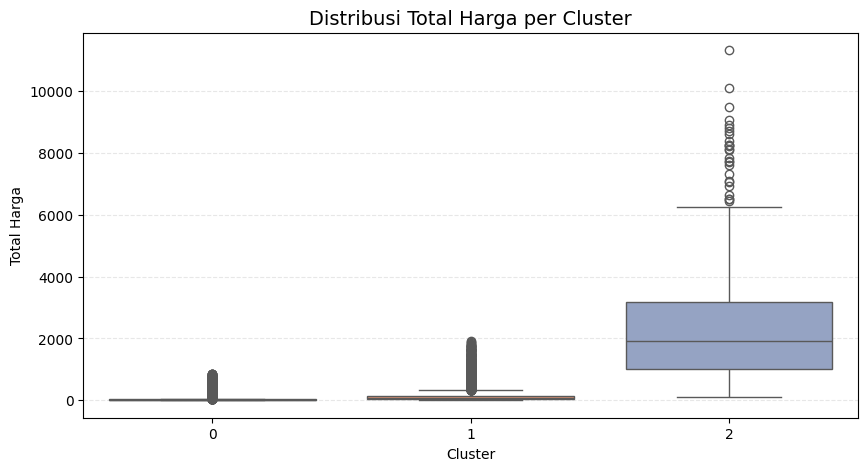

In [102]:
# Distribusi total harga per kluster
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_labeled,
    x='Cluster',
    y='Total_Price',
    palette='Set2',
    whis=1.5  # Atur panjang whisker
)
plt.title('Distribusi Total Harga per Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Total Harga')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

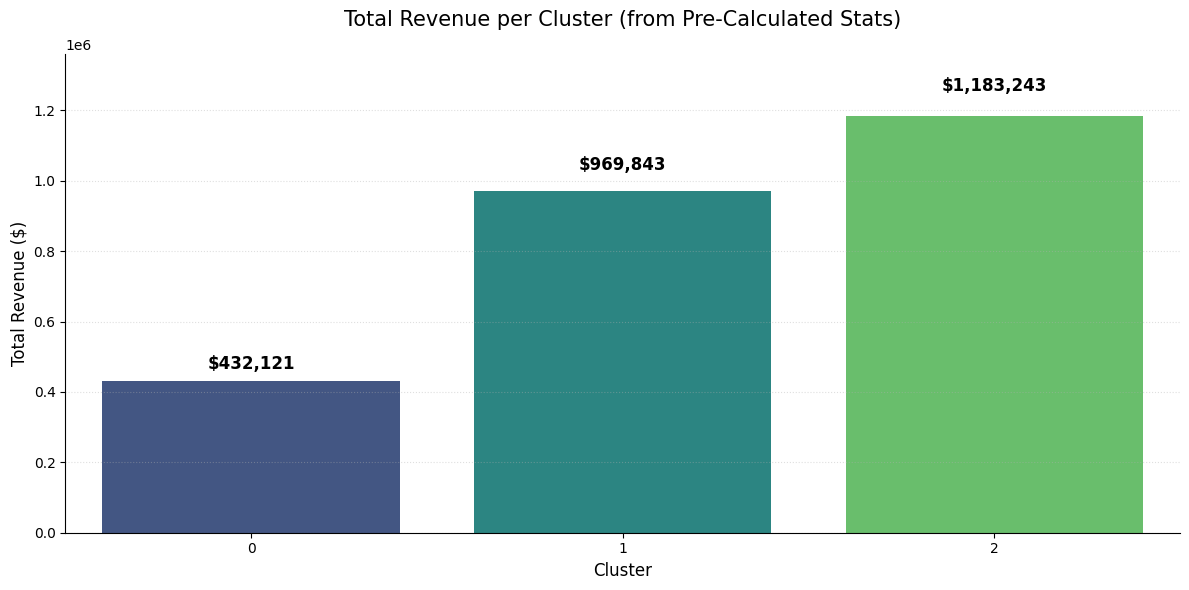

In [103]:
# Visualisasi total revenue
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_labeled,
    x='Cluster',
    y='Total_Price',
    estimator='sum',
    ci=None,
    palette='viridis',
    saturation=0.8
)
for i, val in enumerate(cluster_stats[('Total_Price', 'sum')]):
    ax.text(i, val * 1.05, f'${val:,.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title('Total Revenue per Cluster (from Pre-Calculated Stats)', fontsize=15, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.ylim(0, cluster_stats[('Total_Price', 'sum')].max() * 1.15)
plt.grid(axis='y', linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()


In [104]:
count_stats = df_labeled['Cluster'].value_counts().sort_index().reset_index()
count_stats.columns = ['Cluster', 'Jumlah']
count_stats['Persentase'] = (count_stats['Jumlah'] / len(df_labeled) * 100).round(1)
print(count_stats)

   Cluster  Jumlah  Persentase
0        0   12627        63.1
1        1    6879        34.4
2        2     494         2.5


# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan berdasarkan dari klusterisasi berdasarkan tipe pelanggan, harga per unit, jumlah produk yang terjual, diskon, total harga, total pendapatan per kluster.

## Cluster 0 (Pembelian banyak dengan harga yang rendah):
- **Tipe Pelanggan 100 % B2C (Business to Customer)**
- **Harga per unit (USD):** Terendah di harga 0,46 dan tertinggi di harga 72,70 dan memiliki harga rata-rata sebesar 4,30.  
- **Jumlah produk yang terjual sebanyak :** 12.627 pcs dan memiliki presentase 63.1 % dari total 20.000 produk yang terjual.
- **Diskon :** Pada cluster ini pelanggan tidak mendapatkan diskon sama sekali.
- **Total harga (USD):** Pada cluster ini diperoleh rata-rata total harga 34,22 dengan harga minimal 0,46 dan maksimal 856,65.
- **Total pendapatan yang dihasilkan sebesar 432,121 $**      
- **Analisis:** Cluster ini mungkin bertipe konsumen akhir dengan pembelian yang banyak dan harga yang rendah. Terlihat bahwasannya di kluster ini produk yang dijual tanpa memiliki program diskon serta menyumbang pendapatan terkecil dibanding dengan cluster 1 & 2.

## Cluster 1 (Pembelian relatif banyak dengan variatif) :
- **Tipe Pelanggan 100 % B2B (Business to Business)**
- **Harga per unit (USD):** Terendah di harga 0,32 dan tertinggi di harga 56,65 dan memiliki harga rata-rata sebesar 3,42.  
- **Jumlah produk yang terjual sebanyak :** 6.879 pcs dan memiliki presentase 34,4 % dari total 20.000 produk yang terjual.
- **Diskon :** Pada cluster ini diskon yang diberikan relatif konsisten di angka rata-rata 8,31 %.
- **Total harga (USD):** Pada cluster ini diperoleh rata-rata total harga 140,98 dengan harga minimal 0,39 dan maksimal 1917,75.
- **Total pendapatan yang dihasilkan sebesar 969,843 $**      
- **Analisis:** Cluster ini mungkin bertipe pelanggan ritel dengan pembelian dengan jumlah yang relatif banyak serta diskon produk yang relatif konsisten diberikan meskipun memiliki harga per unit yang lebih murah tetapi cluster ini menyumbang pendapatan yang relatif tinggi berada diantara cluster 0 & 2.

## Cluster 2 (Pembelian sedikit dengan harga yang tinggi):
- **Tipe Pelanggan 39,7 % B2C dan 60,3 % B2B**
- **Harga per unit (USD):** Terendah di harga 24,07 dan tertinggi di harga 137,36 dan memiliki harga rata-rata sebesar 75,40.  
- **Jumlah produk yang terjual sebanyak :** 494 pcs dan memiliki presentase 2,5 % dari total 20.000 produk yang terjual.
- **Diskon :** Pada cluster ini diskon yang diberikan relatif rendah di angka 5,77 % dan ada beberapa pembelian yang tidak diserta diskon.
- **Total harga (USD):** Pada cluster ini diperoleh rata-rata total harga 2395,22 dengan harga minimal 106,01 dan maksimal 11325,33.
- **Total pendapatan yang dihasilkan sebesar 1,183,243 $**      
- **Analisis:** Cluster ini mungkin bertipe pelanggan premium dengan pembelian dengan jumlah yang relatif sedikit serta diskon produk yang relatif rendah dan ada beberapa pembelian yang tidak disertai diskon. Meskipun cluster ini memiliki pembelian yang paling sedikit dibanding cluster 0 & 1 tetapi menyumbang pendapatan tertinggi.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [105]:
df_labeled.to_csv('Dataset_clustering.csv', index=False)
print("File CSV berhasil disimpan")

File CSV berhasil disimpan
